In [16]:
import math
import time
from typing import Iterable
import  torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data as td

定义变量

In [17]:
# loading data
def loading_minist_data(batch_siz:int, works:int)->(Iterable,Iterable):

    train_set = torchvision.datasets.MNIST(root="./data",train=True,transform=torchvision.transforms.ToTensor(),download=True)
    test_set = torchvision.datasets.MNIST(root="./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)
    return td.DataLoader(dataset=train_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True), td.DataLoader(dataset=test_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True)



In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
num_works = 4
batch_size = 64
img_shape  = (28,28)
input_dim= 100
epochs = 25
print("cuda ",cuda)
print("run on ",device.type)
train_iter ,test_iter = loading_minist_data(batch_size,4)
print("train_iter len ",len(train_iter))
print("all size ",len(train_iter)*batch_size)

# x= torch.ones(size=(2,5))
# y =torch.randint(100,size=(2,5))
# print(x)
# print(y)
# x = torch.mul(x,y)
# x
# em = nn.Embedding(10,10)
# x = torch.randint(10,size=(16,1))
# print(x)

cuda  False
run on  cpu
train_iter len  937
all size  59968


In [85]:

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # 2*28*28 to 64*14*14
            nn.Conv2d(2,64,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(0.01),
            # 64*14*14 to 64*7*7
            nn.Conv2d(64,64,kernel_size=3,padding=1,stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            # to 128*3*3
            nn.Conv2d(64,128,kernel_size=3,stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Flatten(),
            nn.Linear(128*3*3,1),
            nn.Sigmoid(),
        ).to(device)
        self.running_loss=0
        self.embedding = nn.Embedding(10,math.prod(img_shape)).to(device)
        self.loss_func = nn.BCELoss()
        self.loss_metric=[]
        self.optimizer = torch.optim.Adam(self.parameters(),lr=0.001)
        pass
    def forward(self,inputs,labels):
        label_embedding = self.embedding(labels)
        label_embedding = label_embedding.view(batch_size,1,28,28)
        inputs = torch.cat((inputs,label_embedding),1)
        # print("label shape ",label_embedding.shape)
        # print("input shape ",inputs.shape)
        for op in  self.model:
            # print(inputs.shape)
            inputs = op(inputs)
        return inputs
    def train(self,inputs,labels,targets):
        out = self.forward(inputs,labels)
        loss = self.loss_func(out,targets)
        self.running_loss += loss.detach().item()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    def evaluate_loss(self):
        ts = self.running_loss/(len(train_iter)*batch_size)
        self.loss_metric.append(ts)

        self.running_loss=0

        pass
class Generator(nn.Module):
    def __init__(self,in_dim:int):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim,256*7*7),
            View( shape=(batch_size,256,7,7) ),
            # 256*7*7 -> 128*14*14
            # 7 + (2-1)*6 +
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            # to 64*14*14
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            # to 1*28*28
            nn.ConvTranspose2d(64,1,kernel_size=4,padding=1,stride=2),
            nn.Tanh()
        ).to(device)
        self.embedding = nn.Embedding(10,in_dim)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        # counter and accumulator for progress
        self.loss_metric = []
        self.running_loss =0
    def forward(self,inputs,labels):
        label_embedding = self.embedding(labels).squeeze(dim=1)
        # print("label emdedding",label_embedding.shape)
        inputs = torch.mul(inputs,label_embedding)
        # print(inputs.shape)
        for op in  self.model:
            # print(inputs.shape)
            inputs = op(inputs)
        return  inputs
    def train(self,D:Discriminator,labels,inputs,targets):
        gen_out = self.forward(inputs,labels)
        # print(gen_out.shape)
        d_out = D.forward(gen_out,labels)
        loss  = D.loss_func(d_out,targets)
        self.running_loss += loss.detach().item()
        # print(self.running_loss)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    def evaluate_loss(self):
        print("G running loss ",self.running_loss)
        ts = self.running_loss/(len(train_iter)*batch_size)
        self.loss_metric.append(ts)
        self.running_loss=0
        pass
def generate_random_seed(size):
    random_data = torch.randn(size*batch_size).view(batch_size,size)
    return random_data.to(device)


In [86]:
# G = Generator(in_dim=input_dim)
# z = generate_random_seed(input_dim)
# la = torch.randint(10,size=(batch_size,1))
# print("z shape {},la shape {}".format(z.shape,la.shape) )
# G.forward(z,la)
# for it ,l in train_iter:
#     it = it.to(device)
#     y = torch.ones(size=(64,1),dtype=torch.float32)
#     y = y.to(device)
#     D.train(it,l,y)
#     break


In [87]:
# D = Discriminator()
# for k in  range(3):
#     time_start = time.time()
#     for it,l in train_iter:
#         it = it.to(device)
#         y = torch.ones(size=(64,1),dtype=torch.float32)
#         y = y.to(device)
#         D.train(it,l,y)
#     # print(len(train_iter)*batch_size)
#     print("spend time  : ",time.time()-time_start)
#     print(D.running_loss/(len(train_iter)*batch_size))
#     D.running_loss =0

generate nums is run on  cpu


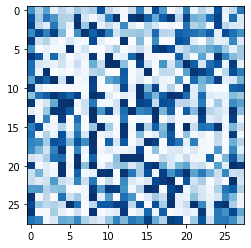

In [88]:
G = Generator(input_dim)

print("generate nums is run on ",generate_random_seed(input_dim).device)
labels =  torch.randint(10,size=(batch_size,1))
output = G.forward(generate_random_seed(input_dim),labels)
# img = output.detach().numpy().reshape(28,28)
plt.imshow(output.cpu().detach().numpy()[0][0], interpolation='none', cmap='Blues')

In [95]:
%%time
D = Discriminator()
G = Generator(input_dim)
for i in range(epochs):
    print("epoch  {} of {}  ".format(i+1,epochs))
    true_tar= torch.ones(size=(batch_size,1),dtype=torch.float32).to(device)
    fake_tar = torch.zeros(size=(batch_size,1),dtype=torch.float32).to(device)
    time_start = time.time()
    for tr_item,labels in train_iter:
        # print(labels.shape)
        # print(G.embedding(labels).shape)
        tr_item = tr_item.to(device)
        labels = labels.to(device)
        gen_item = generate_random_seed(input_dim)
        gen_label = torch.randint(10,size=(batch_size,))
        # print(gen_label.shape)
        # tran true label
        D.train(tr_item,labels,true_tar)
        # train fake generator
        D.train(G.forward(gen_item,labels).detach(),labels,fake_tar)
        #
        G.train(D,gen_label,gen_item,true_tar)
    D.evaluate_loss()
    G.evaluate_loss()
    print("spend time {}   D loss {} ,G loss {} ".format(time.time()-time_start,D.loss_metric[i],G.loss_metric[i]))

        # break

epoch  1 of 25  


KeyboardInterrupt: 

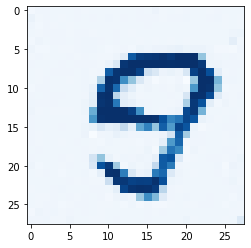

In [62]:
output = G.forward(generate_random_seed(input_dim))
img = output.detach().cpu().numpy().reshape(64,28,28)
plt.imshow(img[9], interpolation='none', cmap='Blues')

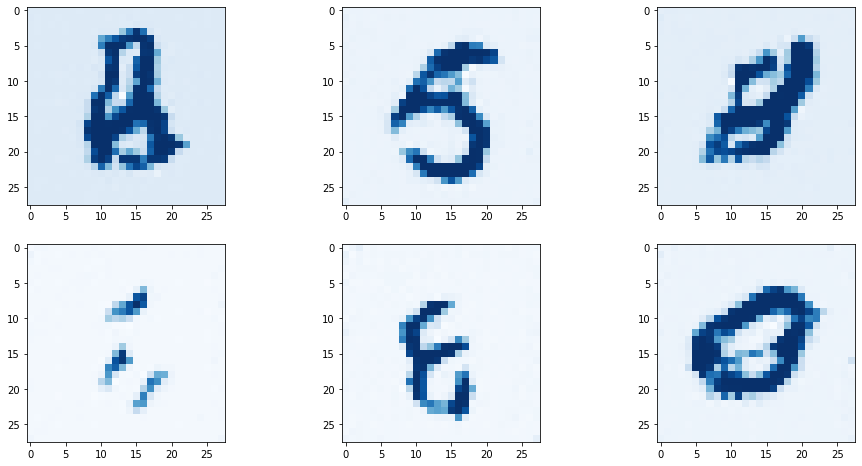

In [63]:
# f,axarr = plt.subplots(2,3, figsize=(16,8))
# for i in range(2):
#     for j in range(3):
#         output = G.forward(generate_random_seed(input_dim))
#         img = output.detach().cpu().numpy()[i*3+j].reshape(28,28)
#         axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

# for it,_ in train_iter:
    # plt.imshow(it[0].reshape(28,28),cmap="Blues")
    # break